[참고](https://velog.io/@jadenkim5179/%EB%B0%91%EB%B0%94%EB%8B%A5-%EB%94%A5%EB%9F%AC%EB%8B%9D-im2col-%EA%B5%AC%ED%98%84-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0)

[참고2](https://velog.io/@clayryu328/%EB%B0%91%EB%B0%94%EB%8B%A5%EB%B6%80%ED%84%B0-%EC%8B%9C%EC%9E%91%ED%95%98%EB%8A%94-%EB%94%A5%EB%9F%AC%EB%8B%9D-17-max-pooling-im2col)

In [2]:
import numpy as np

def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    """다수의 이미지를 입력받아 2차원 배열로 변환한다(평탄화).
    
    Parameters
    ----------
    input_data : 4차원 배열 형태의 입력 데이터 (이미지 수, 채널 수, 높이, 너비)
                 (N, C, H, W) 형상으로, N은 이미지의 수, C는 채널 수, H는 높이, W는 너비
    filter_h : 필터의 높이 (세로 크기)
    filter_w : 필터의 너비 (가로 크기)
    stride : 스트라이드 (기본값 1), 필터가 슬라이딩 할 때의 간격
    pad : 패딩 (기본값 0), 입력 이미지에 추가할 픽셀 수
    
    Returns
    -------
    col : 2차원 배열
        변환된 2차원 배열. 각 윈도우가 1개의 행(row)으로 평탄화됨.
    """
    
    # 입력 데이터의 크기 (이미지 수, 채널 수, 높이, 너비) 받아오기
    N, C, H, W = input_data.shape

    # 출력 크기 계산
    out_h = (H + 2 * pad - filter_h) // stride + 1  # 출력 높이
    out_w = (W + 2 * pad - filter_w) // stride + 1  # 출력 너비

    # 패딩 적용된 입력 이미지 생성 (배치와 채널에 대해서는 패딩을 적용하지 않음)
    img = np.pad(input_data, [(0, 0), (0, 0), (pad, pad), (pad, pad)], 'constant')

    # 필터의 높이와 너비에 맞게 출력 배열 크기 초기화
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    #col의 출력 크기(out_h, out_w)는 필터가 이미지 위를 슬라이딩할 수 있는 횟수를 나타냅니다. 즉, 출력 이미지의 크기와 대응
    #col 배열은 입력 이미지에서 필터가 슬라이딩하면서 각 영역을 잘라내고, 이를 2차원 배열로 평탄화합니다.

    # y 방향으로 필터의 크기만큼 슬라이딩하며 윈도우의 값을 가져오기
    for y in range(filter_h):  # 필터의 높이만큼 반복
        y_max = y + stride * out_h  # 필터가 세로로 이동할 최대 끝 위치(입력이미지의 height, width를 7,7이라 하고, stride를 1, padding을 0, 필터 h,w를 5,5로 두고 숫자놀이 ㄱㄱ)
        for x in range(filter_w):  # 필터의 너비만큼 반복
            x_max = x + stride * out_w  # 필터가 가로로 이동할 최대 끝 위치

            # 이미지를 슬라이딩하면서 윈도우의 영역을 col 배열에 저장
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]       #행을 우선으로 읽는다. 그다음에 열을 살펴봄.(ex: x1,x2,x3,x4)

    # col 배열을 2차원 배열로 변환 (배치, 출력 크기, 채널, 필터 크기 순으로 차원을 재배열) 
    # 그니까 transpose(0, 4, 5, 1, 2, 3)는 (N, out_h, out_w, C, filter_h, filter_w)로 재배열 한다는 소리. transpose는 배열의 차원 순서를 변경하는 연산.
    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N * out_h * out_w, -1)    #재배열을 하고, N*out_h*out_w 만큼 행을 배열하고 열은 자동으로 배열한다.(열을 C*f_h*f_w)
    
    return col


In [3]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W=W
        self.b=b
        self.stride=stride
        self.pad=pad

    def forward(self,x):
        FN,C,FH,FW=self.W.shape
        N,C,H,W=x.shape
        out_h=int(1+(H+2*self.pad-FH)/self.stride)
        out_w=int(1+(W+2*self.pad-FW)/self.stride)

        col=im2col(x,FH,FW,self.stride,self.pad)
        col_w=self.W.reshape(FN,-1).T
        out=np.dot(col,col_w)+self.b                    #행렬곱 사용함.

        out=out.reshape(N,out_h,out_w,-1).transpose(0,3,1,2)
        
        return out


In [ ]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    """(im2col과 반대) 2차원 배열을 입력받아 다수의 이미지 묶음으로 변환한다.
    
    Parameters
    ----------
    col : 2차원 배열(입력 데이터)
    input_shape : 원래 이미지 데이터의 형상（예：(10, 1, 28, 28)）
    filter_h : 필터의 높이
    filter_w : 필터의 너비
    stride : 스트라이드
    pad : 패딩
    
    Returns
    -------
    img : 변환된 이미지들
    """
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))         
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

![사진](convolution_for_back.png)

[강의링크](https://www.youtube.com/watch?v=OHCaMC0hMtI)

In [ ]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 중간 데이터（backward 시 사용）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 가중치와 편향 매개변수의 기울기
        self.dW = None
        self.db = None

    def forward(self, x):                   
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T

        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2) #forward에서 reshape해 준것을 backward에서 다시 원상복귀해준다.

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)                  #forward에서 reshape해 준것을 backward에서 다시 원상복귀해준다.

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)                              # col은 (N*OH*OW, C*FH*FW)이고, dout은 (N*OH*OW,FN)임-->self.dW는 (C*FH*FW,FN)이다.
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)        # forward에서의 입력되었던 W 상태로 바꿔준다. (FN,C,FH,FW 형태로)

        dcol = np.dot(dout, self.col_W.T)                               #
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

In [ ]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h=pool_h
        self.pool_w=pool_w
        self.stride=stride
        self.pad=pad
    
    def forward(self,x):
        N,C,H,W=x.shape
        out_h=int(1+(H-self.pool_h)/self.stride)
        out_w=int(1+(W-self.pool_w)/self.stride)

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)

import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient

class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):        #이 convolution에서는 은닉층이 단일이다.
        # 합성곱 층의 파라미터 설정
        filter_num = conv_param['filter_num']  # 필터의 수 (출력 채널)
        filter_size = conv_param['filter_size']  # 필터 크기
        filter_pad = conv_param['pad']  # 패딩 크기
        filter_stride = conv_param['stride']  # 스트라이드 크기
        input_size = input_dim[1]  # 입력 크기 (MNIST의 경우 28)
        
        # 합성곱 출력 크기 계산
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        # 풀링 출력 크기 계산 (2x2 풀링을 사용하므로 크기를 반으로 줄임)
        pool_output_size = int(filter_num * (conv_output_size / 2) * (conv_output_size / 2))   #아래의 self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
                                                                                               #때문에 이걸 쓴다.
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(filter_num, input_dim[0], filter_size, filter_size)   # input_dim[0]은 입력 이미지의 채널 수
                                                                                                                    #그리고 가로세로 길이가 동일해서 filter_size가 두개 들어감.
        self.params['b1'] = np.zeros(filter_num)                        #편향은 필터의 개수에 의존(각 필터에 하나씩 존재, 입력값에는 의존 안함.)
        self.params['W2'] = weight_init_std * np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        # 합성곱 계층
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'], conv_param['stride'], conv_param['pad'])
        # ReLU 활성화 계층
        self.layers['Relu1'] = Relu()
        # 풀링 계층 (2x2 크기, 스트라이드 2)
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        # Affine(fully connected) 계층
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        # 두 번째 ReLU 활성화 계층
        self.layers['Relu2'] = Relu()
        # 두 번째 Affine 계층
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        # 마지막 소프트맥스와 손실 계층
        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        """입력 x에 대한 예측을 수행한다."""
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        """입력 x와 정답 t에 대한 손실을 계산한다."""
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):       #참고로 gradient에서는 배치처리를 안하고 전체적으로 계산을 했지만, accuracy에서는 배치처리로 분할해서 계산함.
        """정확도를 계산한다."""
        if t.ndim != 1:     #원핫 인코딩(예를 들어 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0])일 때 
            t = np.argmax(t, axis=1)  # 정답 레이블을 원핫 벡터에서 정수로 변환     (위의 예시의 경우 3으로...)
        
        acc = 0.0
        for i in range(int(x.shape[0] / batch_size)):    #x.shape[0]은 입력 데이터 x의 전체 샘플 수
            tx = x[i*batch_size:(i+1)*batch_size]  # 배치 단위로 데이터 분할
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)  # 예측값
            y = np.argmax(y, axis=1)  # 예측값을 1D 배열로 변환
            acc += np.sum(y == tt)  # 예측이 맞은 갯수 카운트
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):                     #아래의 gradient가 따로 있으니 주의.
        """기울기를 수치미분으로 계산한다."""
        loss_w = lambda w: self.loss(x, t)  # 손실 함수를 람다 함수로 정의

        grads = {}
        for idx in (1, 2, 3):
            # 각 층의 가중치에 대해 수치미분 계산
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 오차역전파법으로 계산한다."""
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1  # 손실 함수의 기울기는 1
        dout = self.last_layer.backward(dout)

        # 계층 역순으로 역전파 수행
        layers = list(self.layers.values())
        layers.reverse()                        #순서를 바꿔줌.
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        """모델의 파라미터를 파일에 저장한다."""
        params = {}                                 #  새로운 딕셔너리 params 생성성
        for key, val in self.params.items():
            params[key] = val                       # 새로운 딕셔너리 params에 저장
        with open(file_name, 'wb') as f:            # 'wb' 모드는 바이너리 쓰기(pickle은 객체를 이진형식으로 저장한다.)
            pickle.dump(params, f)                  # pickle.dump()는 파이썬 객체를 파일에 저장하는 함수(파일 객체 f에 params를 dump(저장)함.)

    def load_params(self, file_name="params.pkl"):
        """파일에서 모델의 파라미터를 로드한다."""
        with open(os.path.dirname(__file__) + '/' + file_name, 'rb') as f:          #'rb'는 read binary
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):       #enumerate는 파이썬에서 반복 가능한 객체(iterable)를 순회하면서 인덱스와 값을 동시에 반환하는 함수
            # 각 계층에 파라미터 로드
            self.layers[key].W = self.params['W' + str(i+1)]            #각각의 class의 self.W와 self.b에 값들을 저장.
            self.layers[key].b = self.params['b' + str(i+1)]


train loss:2.300736457643319
=== epoch:1, train acc:0.208, test acc:0.221 ===
train loss:2.2988907334886863
train loss:2.2969536370495387
train loss:2.291843462075748
train loss:2.285538358223709
train loss:2.2801845415063
train loss:2.2610518039330127
train loss:2.251178439710075
train loss:2.2461938442011338
train loss:2.2081397650394923
train loss:2.200117829696899
train loss:2.168128890651122
train loss:2.115663750909967
train loss:2.0977460078378893
train loss:2.033019918681853
train loss:1.9885904710757134
train loss:1.888799455717433
train loss:1.7912619459917116
train loss:1.7369246225169275
train loss:1.7705761833190174
train loss:1.687212086843517
train loss:1.4972112809730813
train loss:1.4557660370266763
train loss:1.2930956146542862
train loss:1.2356554749300086
train loss:1.195330866602896
train loss:1.105907764717787
train loss:1.0617013318386128
train loss:0.9339049786455577
train loss:0.9693797380817587
train loss:0.8236253132897633
train loss:0.8976454250140651
train 

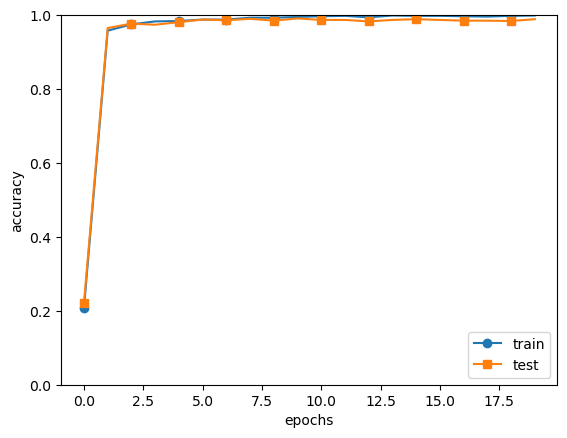

In [2]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)

import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from simple_convnet import SimpleConvNet
from common.trainer import Trainer

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

# 시간이 오래 걸릴 경우 데이터를 줄인다.
#x_train, t_train = x_train[:5000], t_train[:5000]
#x_test, t_test = x_test[:1000], t_test[:1000]

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# 매개변수 보존
network.save_params("params.pkl")
print("Saved Network Parameters!")

# 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()